In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.dao import db_utils as db

# 载入张量
all_sim = torch.load("res/all_sim.pt")
avs = torch.load('res/author_vec_set.pt')
avs_2d = torch.load("res/author_vec_set_2d.pt")

# 定义变量
author_set = db.get_all_name_en()

print("Jupyter: ACRS on Position!")

Jupyter: ACRS on Position!


In [ ]:
# all_sim.pt to csv
# 填充对称矩阵
for i in range(len(all_sim)):
    for j in range(all_sim):
        all_sim[i][j] = all_sim[j][i]
pd.DataFrame(all_sim.numpy(), columns=author_set, index=author_set).to_csv("res/all_sim.csv")

In [6]:
# author_vec_set.pt to csv
pd.DataFrame(avs.numpy(), index=author_set).to_csv("res/author_vec_set.csv")
pd.DataFrame(avs_2d, index=author_set).to_csv("res/author_vec_set_2d.csv")

In [4]:
from sklearn.datasets import make_blobs

centers = [[20, 1], [-2, -1], [2, -1]]  # 三个中心点的坐标
# datas为样本数据集，labels_true为样本数据集的标签
datas, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                                random_state=0)
print(type(datas))
print(datas.shape)
print(datas)

<class 'numpy.ndarray'>
(750, 2)
[[19.84022039  1.14802236]
 [-2.15474834 -1.2041171 ]
 [19.67863613  0.72418009]
 ...
 [ 1.26798858 -1.27833405]
 [-1.88628813 -0.30293249]
 [ 1.60046048 -1.29605472]]


上方为datas表格-------------------------------


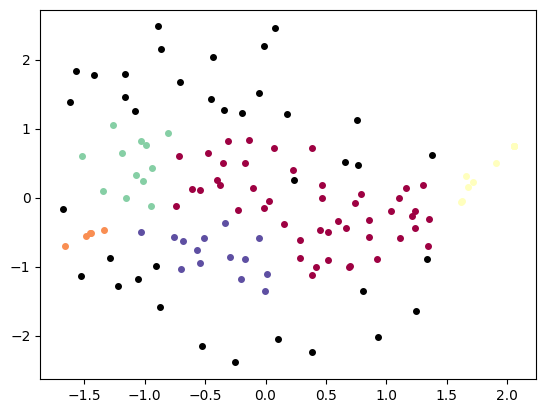

[ 0  1  1 -1  4  1  1  2  1  1 -1  1 -1 -1 -1  1  1  1  0  3  1  1  1  3
  3 -1 -1 -1 -1  1  1  0  4  1  1  1  4  1 -1 -1 -1  1  1  1 -1  1  1  1
  0  3 -1  3 -1  1 -1  0 -1  3 -1  4  0 -1  0 -1  2  0  1 -1  1 -1  0  1
 -1  1  1 -1  1  4  1  4 -1 -1 -1  1 -1  4 -1 -1  1  1  3  2  0  3 -1  4
  1  4  1  1  1  3  1 -1  0  4 -1  1  0  0 -1  1  1 -1  4  4  1 -1  2 -1
  1  0  3  2  1  3]


In [132]:
# DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

UNCLASSIFIED = 0  # 点未被标记
NOISE = -1  # 噪声点标记


# 计算数据点两两之间的距离
def getDistanceMatrix(datas):  # datas 是聚类数据
    N, D = np.shape(datas)  # 读取datas的维度，维度是N x D（N指数据个数，D指特征维度）   ，shape函数用于获取矩阵的形状
    dists = np.zeros([N, N])  # zeros 函数：返回一个给定形状和类型的用0填充的数组，

    for i in range(N):
        for j in range(N):
            vi = datas[i, :]  # 切片 [开始,结束]
            vj = datas[j, :]
            dists[i, j] = np.sqrt(np.dot((vi - vj), (vi - vj)))  # 欧式距离函数,返回点与点之间距离的数组
    return dists


#  寻找以点cluster_id 为中心，eps 为半径的圆内的所有点的id
def find_points_in_eps(point_id, eps, dists):
    index = dists[point_id] <= eps  # dists[point_id] 即：point_id 与 所有点的距离
    return np.where(index)[0].tolist()  # 返回所有符合的点的集合


def expand_cluster(dists, labs, cluster_id, seeds, eps, min_points):
    """
    聚类扩展
    :param dists: 任意数据两两之间的距离  N x N
    :param labs: 所有数据的标签 labs N
    :param cluster_id: 一个簇的标号
    :param seeds: 密度评估半径
    :param eps: 用来进行簇扩展的点
    :param min_points: 半径内最少的点数
    :return:
    """
    i = 0
    while i < len(seeds):
        Pn = seeds[i]  # 获取一个点
        if labs[Pn] == NOISE:  # 如果是噪声点，则重新标记
            labs[Pn] = cluster_id
        elif labs[Pn] == UNCLASSIFIED:  # 如果未被标记过，则进行标记
            labs[Pn] = cluster_id
            new_seeds = find_points_in_eps(Pn, eps, dists)  # 以新点为圆心再画圈，进行扩展
            if len(new_seeds) >= min_points:  # 如果扩张的圈中数够多，则加入到seeds队列中
                seeds = seeds + new_seeds
        i += 1
        # 通过挨个标记和扩展seeds里的数字，实现聚类过程


def dbscan(datas, eps, min_points):
    dists = getDistanceMatrix(datas)  # 获取点与点之间的距离，且以二维数组的形式
    # 将所有点的标签初始化为0
    n_points = datas.shape[0]  # shape[0]指读取读取矩阵第一维的长度
    labs = [UNCLASSIFIED] * n_points

    cluster_id = 0
    # 遍历所有点
    for point_id in range(n_points):
        if labs[point_id] != UNCLASSIFIED:  # 如果被标记，则结束此次循环，表示该点已处理过
            continue  # 没有处理过，则计算寻找临近点
        seeds = find_points_in_eps(point_id, eps, dists)  # 符合条件的点存到seeds中

        if len(seeds) < min_points:  # 如果临近点过少，则标记为噪声点
            labs[point_id] = NOISE
        else:  # 否则开启新一轮扩张
            cluster_id = cluster_id + 1
            labs[point_id] = cluster_id  # 标记当前点
            expand_cluster(dists, labs, cluster_id, seeds, eps, min_points)
    return labs, cluster_id


def draw_cluster(datas, labs, n_cluster):
    """
    绘图
    :param datas: 数据
    :param labs: 聚类结果
    :param n_cluster: 聚类个数
    :return: 绘图
    """
    plt.cla()
    # 设计颜色
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, n_cluster)]  # (起点，终点，几个元素)

    # 遍历所有点的坐标
    for i, lab in enumerate(labs):
        if lab == NOISE:  # 如果是噪声点 则为黑色
            plt.scatter(datas[i, 0], datas[i, 1], s=16., color=(0, 0, 0))
        else:  # 否则，根据类别的编号，来标记颜色
            plt.scatter(datas[i, 0], datas[i, 1], s=16., color=colors[lab - 1])
    plt.show()


## 数据1
# centers = [[20, 1], [-2, -1], [2, -1]]  # 三个中心点的坐标
# # datas为样本数据集，labels_true为样本数据集的标签
# datas, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                                 random_state=0)
# 产生一组随机数datas，中心点是centers，方差是0.4，产生750个点

## 数据2
# file_name = "spiral"
# with open(file_name+".txt","r",encoding="utf-8") as f:
#    lines = f.read().splitlines()
# lines = [line.split("\t")[:-1] for line in lines]
# datas = np.array(lines).astype(np.float32)


# 数据正则化，让参与的数据减去均值出方差，是临均值，标准差成了1
datas = StandardScaler().fit_transform(avs_2d)  # 计算训练数据的均值和方差，并基于计算出来的均值和方差来转换训练数据，从而把数据转换成标准的正态分布
eps = 0.35
min_points = 5

# 手动实现DBSCAN
# dbscan算法，labs是最终结果，cluster_num 是分成了多少类
labs, cluster_num = dbscan(datas, eps=eps, min_points=min_points)
# print("labs of my dbscan")
# print(labs)

# sklearn里的DBSCAN 算法
# 分类器     # 半径      min_points           对datas进行聚类
clustering = DBSCAN(eps=eps, min_samples=min_points).fit(datas)
skl_labels = clustering.labels_
# print("labs of sk-DBSCAN")
# print(skl_labels)
# 画出
print("上方为datas表格-------------------------------")
draw_cluster(datas, skl_labels, cluster_num)

# dbscan 输出，123表示聚类点，-1表示噪声点
# sklearn 输出  012表示聚类点，-1表示噪声点
print(skl_labels)


In [133]:
# 将 cluster_id 与学者对应并保存 csv
a = np.array(author_set)[:,np.newaxis]  # 转置
s = np.array(skl_labels)[:,np.newaxis]
res = np.hstack((a,s,datas))
pd.DataFrame(res, columns=['author', 'cluster_id','x','y'])

,author,cluster_id,x,y
0,Anfu_Zhou,0,-0.5662251,-0.75728613
1,Hongman_Wang,1,-0.6052065,0.12589268
2,Xiangling_Fu,1,1.2330681,-0.44702983
3,Yang_Liu_0024,-1,0.8030962,-1.3535779
4,Pengfei_Wang_0009,4,-0.8027786,0.94273686
...,...,...,...,...
121,Xiaolong_Zheng_0002,0,-0.54313916,-0.9420552
122,Shujie_Yang,3,1.7178674,0.22148886
123,Xiao-hong_Huang,2,-1.6611723,-0.6968296
124,Zhipeng_Gao,1,-0.5406457,0.10640212


In [134]:
center = []
for i in range(cluster_num):
    center.append(np.mean(datas[skl_labels == i], axis=0))
center = np.array(center)
print(center)

[[-0.41625836 -0.8094744 ]
 [ 0.3915307  -0.1415399 ]
 [-1.4735618  -0.54974335]
 [ 1.8593634   0.43517905]
 [-1.1050011   0.480263  ]]


In [135]:
# 获取噪声点的坐标
noise = datas[skl_labels == -1]

# 计算距离公式为：

$$
(x-x_{center})^2+(y-y_{center})^2
$$



> 注意：
在使用Numpy时，如果array后面加了condition，则**无法直接修改其内容**（应该是算法没有实现记录对应的index，耽误了好久时间...）

### 记录每个噪声点在res中的索引

In [137]:
noise_index = []
print(skl_labels)
for i in range(len(skl_labels)):
    if skl_labels[i] == -1:
        noise_index.append(i)
print(noise_index)

[ 0  1  1 -1  4  1  1  2  1  1 -1  1 -1 -1 -1  1  1  1  0  3  1  1  1  3
  3 -1 -1 -1 -1  1  1  0  4  1  1  1  4  1 -1 -1 -1  1  1  1 -1  1  1  1
  0  3 -1  3 -1  1 -1  0 -1  3 -1  4  0 -1  0 -1  2  0  1 -1  1 -1  0  1
 -1  1  1 -1  1  4  1  4 -1 -1 -1  1 -1  4 -1 -1  1  1  3  2  0  3 -1  4
  1  4  1  1  1  3  1 -1  0  4 -1  1  0  0 -1  1  1 -1  4  4  1 -1  2 -1
  1  0  3  2  1  3]
[3, 10, 12, 13, 14, 25, 26, 27, 28, 38, 39, 40, 44, 50, 52, 54, 56, 58, 61, 63, 67, 69, 72, 75, 80, 81, 82, 84, 86, 87, 94, 103, 106, 110, 113, 117, 119]


### 利用上述公式，计算距离，根据距离修改标签

In [138]:
for i in range(len(noise)):
    dis = np.sum((noise[i] - center) ** 2, axis=1)
    #argmin返回最小值的索引
    res = np.argmin(dis)
    #将噪声点的skl_labels改为最近的簇的skl_labels
    index=noise_index[i]
    skl_labels[index] = res

# 更新后的标签

In [139]:
print(skl_labels)

[0 1 1 1 4 1 1 2 1 1 2 1 1 4 4 1 1 1 0 3 1 1 1 3 3 4 4 1 4 1 1 0 4 1 1 1 4
 1 0 4 0 1 1 1 0 1 1 1 0 3 1 3 4 1 2 0 4 3 4 4 0 4 0 0 2 0 1 4 1 4 0 1 0 1
 1 1 1 4 1 4 2 4 1 1 0 4 0 3 1 1 3 2 0 3 1 4 1 4 1 1 1 3 1 4 0 4 0 1 0 0 4
 1 1 4 4 4 1 2 2 3 1 0 3 2 1 3]


# 更新后的表格

In [140]:
a = np.array(author_set)[:, np.newaxis]  # 转置
s = np.array(skl_labels)[:, np.newaxis]
res = np.hstack((a, s, datas))
pd.DataFrame(res, columns=['author', 'cluster_id', 'x', 'y'])

,author,cluster_id,x,y
0,Anfu_Zhou,0,-0.5662251,-0.75728613
1,Hongman_Wang,1,-0.6052065,0.12589268
2,Xiangling_Fu,1,1.2330681,-0.44702983
3,Yang_Liu_0024,1,0.8030962,-1.3535779
4,Pengfei_Wang_0009,4,-0.8027786,0.94273686
...,...,...,...,...
121,Xiaolong_Zheng_0002,0,-0.54313916,-0.9420552
122,Shujie_Yang,3,1.7178674,0.22148886
123,Xiao-hong_Huang,2,-1.6611723,-0.6968296
124,Zhipeng_Gao,1,-0.5406457,0.10640212


# 更新后的图

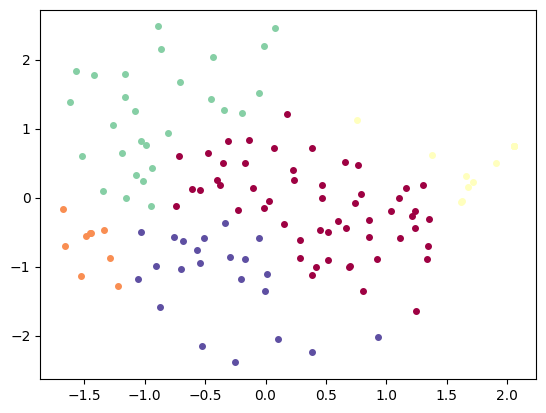

In [141]:
draw_cluster(datas, skl_labels, cluster_num)

In [143]:
pd.DataFrame(res, columns=['author', 'cluster_id', 'x', 'y']).to_csv('res/cluster_result.csv')